In [1]:
using Flux
using Zygote
using Plots

import Pkg
Pkg.status("Flux")

Status `~/.julia/environments/v1.8/Project.toml`
  [587475ba] Flux v0.13.10


In [2]:
#generate some target values from this function (non-linear)
function fn1(x)
    if( x < -5 )
        return 1
    elseif( -5 <= x <= 0 )
        return 2
    else 
        return 2x + 2
    end
end

fn1 (generic function with 1 method)

In [3]:
#span a domain to get the training data and then get some random domain points to test on
x_train, x_test = collect(-10:0.1:10), (rand(200) .* 12) .- 10

([-10.0, -9.9, -9.8, -9.7, -9.6, -9.5, -9.4, -9.3, -9.2, -9.1  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [-3.6241936610886913, -2.009647515511551, -7.315599416936394, -9.851169210446349, -5.3143404574092505, -4.869015919145169, -5.3810450040353075, -1.1106365945031555, -9.277752891701368, -3.6505535011285906  …  -0.3634319488340694, 1.1018181224636763, 0.534467303054015, 1.5221276845924852, -3.8600913866682243, 1.2672860972684283, -9.997114498483457, -3.643015519892108, -0.1979119981475268, -5.248684249318686])

In [4]:
y_train, y_test = fn1.(x_train), fn1.(x_test)

(Real[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0], Real[2, 2, 1, 1, 1, 2, 1, 2, 1, 2  …  2, 4.2036362449273525, 3.06893460610803, 5.04425536918497, 2, 4.534572194536857, 1, 2, 2, 1])

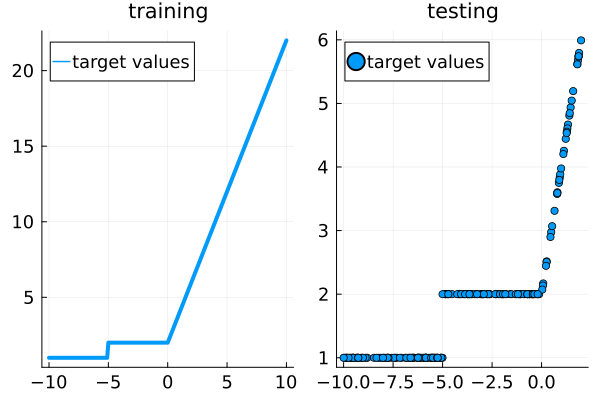

In [5]:
p1 = plot( x_train , y_train , linewidth=4 , title="training" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

In [6]:
#let's make a simple model to predict this data
model = Chain( Dense(1=>20,sigmoid) , Dense(20=>5,relu) , Dense(5=>1) )

Chain(
  Dense(1 => 20, σ),                    # 40 parameters
  Dense(20 => 5, relu),                 # 105 parameters
  Dense(5 => 1),                        # 6 parameters
)                   # Total: 6 arrays, 151 parameters, 988 bytes.

In [7]:
length(model)

3

In [8]:
model[1]

Dense(1 => 20, σ)   # 40 parameters

In [9]:
#look at the weights at initialization
display(model[1].weight)
display(model[2].weight)
display(model[3].weight)

20×1 Matrix{Float32}:
 -0.49577597
  0.18171676
 -0.1491179
 -0.31078342
  0.29045585
  0.16989714
 -0.44867864
 -0.397991
  0.42908007
  0.5101544
  0.35297656
  0.32762113
 -0.19845054
 -0.11288426
 -0.23987392
 -0.42343754
 -0.32028478
 -0.18813764
  0.12416565
 -0.28554788

5×20 Matrix{Float32}:
 -0.199106  -0.403277    0.014226   …  -0.425428    0.376739    0.0792156
  0.115445   0.138807    0.314905       0.0168538   0.323396   -0.488731
 -0.223122   0.391971   -0.0671923     -0.254948   -0.255568   -0.329441
  0.2607    -0.387742    0.0614321      0.124614    0.0991858   0.274809
 -0.476625  -0.0639811   0.131375      -0.113141    0.307015   -0.10478

1×5 Matrix{Float32}:
 0.513513  0.576056  0.581771  0.585788  -0.803854

In [10]:
#put the independent samples along the -columns-
init_predictions = model( hcat(x_test...) )

1×200 Matrix{Float64}:
 0.353681  0.318142  0.389462  0.407686  …  0.354047  0.379031  0.377484

In [11]:
#get the -initial- loss
#let's use mean absolute error (MAE) here rather than MSE to not focus too much on big values
init_loss = Flux.mae( init_predictions' , y_test )

1.629739650284828

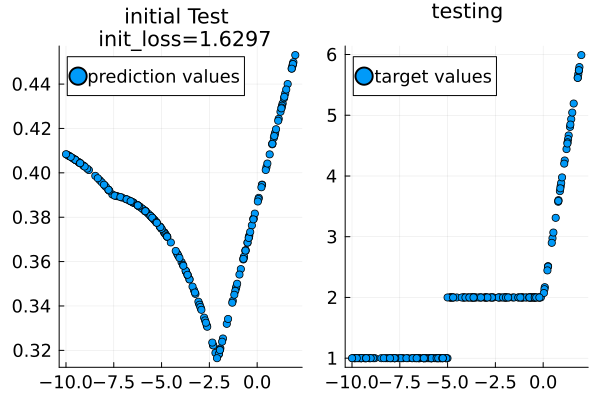

In [12]:
p1 = plot( x_test , init_predictions' , seriestype=:scatter , linewidth=4 , title="initial Test \n init_loss=$(round(init_loss,digits=4))" , 
            label="prediction values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

In [13]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=20, shuffle=true )

MLUtils.DataLoader{Tuple{Vector{Float64}, Vector{Real}}, Random._GLOBAL_RNG, Val{nothing}}(([-10.0, -9.9, -9.8, -9.7, -9.6, -9.5, -9.4, -9.3, -9.2, -9.1  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], Real[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20.2, 20.4, 20.6, 20.8, 21.0, 21.2, 21.4, 21.6, 21.8, 22.0]), 20, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

In [14]:
opt = Flux.setup( Flux.Adam(0.01) , model )

(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(

In [15]:
#train the parameters
loss( model , x , y ) = Flux.mae( model(hcat(x...))' , y )
for epoch in 1:5000
    
    Flux.train!( loss , model , data , opt )
    
end


In [16]:
last_loss = Flux.mae( model( hcat(x_test...) )' , y_test )

0.03759365273895637

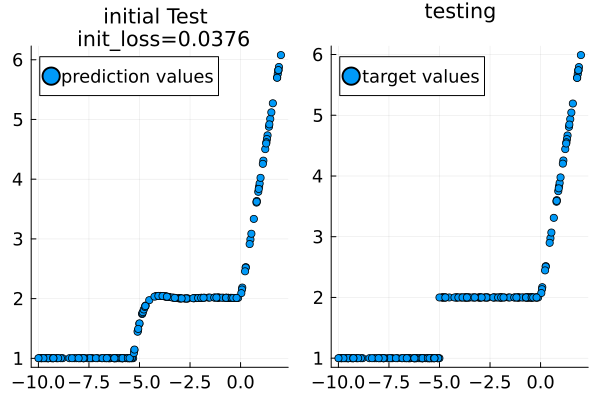

In [17]:
p1 = plot( x_test , model( hcat(x_test...) )' , seriestype=:scatter , linewidth=4 , title="initial Test \n init_loss=$(round(last_loss,digits=4))" , 
            label="prediction values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
p2 = plot( x_test , y_test , seriestype=:scatter , linewidth=4 , title="testing" , label="target values" , legend=:topleft , tickfontsize=12 , legendfontsize=12 )
plot(p1,p2)

### <span style="color:orange"> Let's do some categorical data prediction with the dataset we all are familiar with: **Iris** </span>

There is a nice Julia package to use the plethora of R datasets

In [88]:
using RDatasets

In [89]:
iris = dataset("datasets", "iris")

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


In [90]:
typeof(iris)

DataFrame

In [91]:
iris = Matrix(iris)
typeof(iris)
display( iris[1:3,:])

3×5 Matrix{Any}:
 5.1  3.5  1.4  0.2  "setosa"
 4.9  3.0  1.4  0.2  "setosa"
 4.7  3.2  1.3  0.2  "setosa"

In [92]:
features = iris[:,1:4]
features = Matrix{Float32}(features) #the numbers need to be in Float32
println( typeof( features ) )
targets = iris[:,5];

Matrix{Float32}


In [93]:
length( unique( iris[:,end] ) )

3

In [94]:
length( iris[:,end] )

150

In [104]:
using StatsBase, Random

In [105]:
# rand_inds = randperm(150)
# train_inds = rand_inds[1:100];
# test_inds = rand_inds[101:end];
odd_inds = findall( mod.(1:150,2) .<= 1000)
display(length(odd_inds))
even_inds = findall( mod.(1:150,2) .== 0);

150

In [106]:
x_train , x_test = features[odd_inds,:] , features[even_inds,:];
y_train , y_test = targets[odd_inds] , targets[even_inds];
println( size(x_train) )
x_train = x_train'
x_test = x_test'
println( size(x_train) )

(150, 4)
(4, 150)


In [107]:
#we need to make 1-hot encoding of the categorical values
species = unique( iris[:,end] )
y_train = Flux.onehotbatch( y_train , species )
display( size(y_train) )
y_test = Flux.onehotbatch( y_test , species )

(3, 150)

3×75 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

In [108]:
#make a model for predicting the species (categorical output)
model_iris = Chain(Dense(4=>8,relu),Dense(8=>3),softmax)

Chain(
  Dense(4 => 8, relu),                  # 40 parameters
  Dense(8 => 3),                        # 27 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 67 parameters, 524 bytes.

In [109]:
#test the model
println( "model output = " , model_iris( x_train[:,1] ) )
println( "category output predicted ('one-cold') = " , Flux.onecold( model_iris(x_train[:,1]), species ) )
println( "true output label = " , Flux.onecold( y_train[:,1], species ) )
#try out the cross entropy
println( "cross entropy of prediction and target = " , Flux.crossentropy( model_iris( x_train[:,1] ) , y_train[:,1] ) )
println( "cross entropy of predictions and multiple targets = " , Flux.crossentropy( model_iris( x_train[:,1:20] ) , y_train[:,1:20] ) )
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
accuracy = 100 * sum( hits ) / length( hits )
println( "init accuracy = ", accuracy , "%")

model output = Float32[0.516886, 0.48283795, 0.0002760454]
category output predicted ('one-cold') = setosa
true output label = setosa
cross entropy of prediction and target = 0.65993273
cross entropy of predictions and multiple targets = 0.6522028
init accuracy = 21.333333333333332%


In [110]:
#pack the data
data = Flux.DataLoader( (x_train, y_train) , batchsize=1 , shuffle=false );
#data = [(x_train,y_train)]

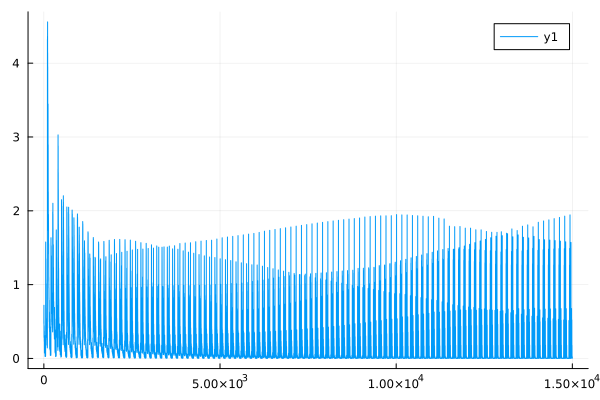

In [112]:
#train the parameters to predict iris
opt = Flux.setup( Flux.Adam(0.001) , model_iris );
losses = []
for epoch in 1:100
    for data_tmp in data    
        #get the gradients
        loss_tmp, grads = Flux.withgradient(model_iris) do model
            y_hat = model(data_tmp[1])
            Flux.crossentropy(y_hat,data_tmp[2])
        end
        Flux.update!(opt, model_iris, grads[1])
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
end
p1 = plot(losses)
savefig("./p1.png")
display(p1)

In [113]:
hits = Flux.onecold( model_iris( x_train ) , species ) .== Flux.onecold( y_train , species )
print( hits )
accuracy = 100 * sum( hits ) / length( hits )
println( "train accuracy = ", accuracy , "%")

hits = Flux.onecold( model_iris( x_test ) , species ) .== Flux.onecold( y_test , species )
print( hits )
accuracy = 100 * sum( hits ) / length( hits )
println( "test accuracy = ", accuracy , "%")

Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]train accuracy = 96.66666666666667%
Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]test accuracy = 97.33333333333333%


In [34]:
pred = model_iris( x_train[:,34] ); println(pred)
spec_tmp = Flux.onecold(pred, species); println(spec_tmp)
tar_tmp = y_train[:,34]; println(tar_tmp)
label_tmp = Flux.onecold(tar_tmp, species); println(label_tmp)

Float32[0.4522612, 0.24774575, 0.29999307]
setosa
Bool[0, 1, 0]
versicolor


In [35]:
x_train

4×75 adjoint(::Matrix{Float32}) with eltype Float32:
 5.1  4.7  5.0  4.6  4.4  5.4  4.8  5.8  …  6.3  6.0  6.7  5.8  6.7  6.3  6.2
 3.5  3.2  3.6  3.4  2.9  3.7  3.0  4.0     3.4  3.0  3.1  2.7  3.3  2.5  3.4
 1.4  1.3  1.4  1.4  1.4  1.5  1.4  1.2     5.6  4.8  5.6  5.1  5.7  5.0  5.4
 0.2  0.2  0.2  0.3  0.2  0.2  0.1  0.2     2.4  1.8  2.4  1.9  2.5  1.9  2.3

In [36]:
# function loss_iris( m , x , y )
#     return Flux.logitcrossentropy( model_iris( x ) , y )
# end
# for epoch in 1:100
#     Flux.train!( loss_iris , model_iris , data , opt )
# end